In [1]:
%matplotlib inline
from __future__ import division, absolute_import
import os
import skimage
from skimage import io
from skimage import color
import numpy as np
from scipy import signal
import scipy.signal.signaltools as sigtool
import matplotlib.pyplot as plt
import src.vvr_toolbox as t

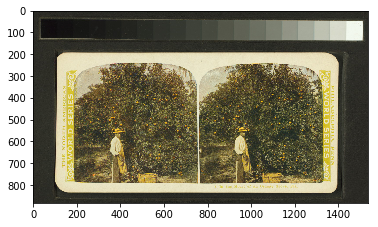

In [9]:
image_number = 9
image_list = t.get_list_of_images('/Volumes/Zweiter/VVR/FL/')
this_image = io.imread('/Volumes/Zweiter/VVR/FL/' + image_list[image_number])
    
plt.imshow(this_image)

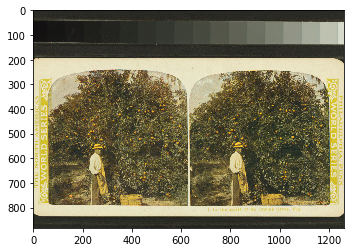

In [10]:
peaks = t.get_max_peaks(this_image)
cropped_image = this_image[:,peaks[0]:peaks[1]]

plt.imshow(cropped_image)

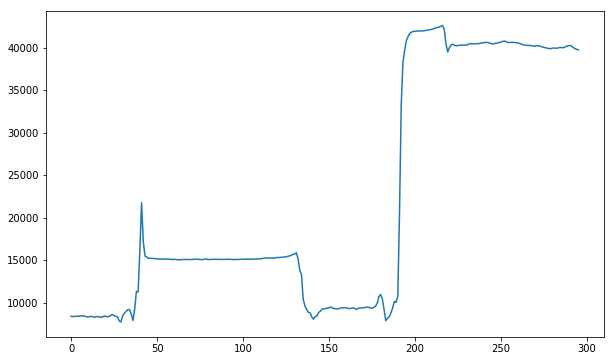

In [16]:
partial = t.get_partial_peaks(this_image, 'height', 0)
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 6))
ax1.plot(partial)

In [15]:
test_image = io.imread('./tests/data/test_wide.png')
gray_image = t.get_lum_channel(test_image)
sample = t.get_partial_peaks(test_image, 'width', 0)
sums = t.get_luma_sums(gray_image, 'width')
test = t.smooth_values(sums)
print(test)

[ 300.  300.  300.  300.  300.  300.  300.  300.  300.    0.    0.    0.
    0.    0.    0.    0.    0.    0.  300.  300.  300.  300.  300.  300.
  300.  300.  300.]


In [13]:
img_luma = t.get_lum_channel(this_image)

width_sums = t.get_luma_sums(img_luma, 'width')
width_binary = t.make_luma_binary(width_sums, 'width')

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 6))
# ax1.imshow(this_image)
# ax1.plot(t.make_luma_binary(width_sums)*800)
# ax1.plot(width_sums)
first_third = t.get_end_third(width_sums, 0)
ax1.plot(first_third)

IndexError: tuple index out of range

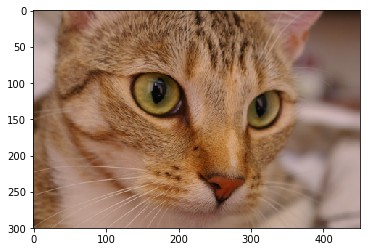

In [3]:
import skimage.data
img = skimage.data.chelsea()
middle = t.get_mid_section(img, 'tall')
plt.imshow(img)